In [1]:
import tqdm
import torch
import datasets
import transformers
import numpy as np
import matplotlib.pyplot as plt
from models import unet

## Loading the data

In [2]:
dataset = datasets.TDSC(path_to_dataset="data/tdsc", transformers=[transformers.ResizerTransformer(target_size=(256,256)), transformers.Normalizer(), transformers.ToTensorTransformer()])

In [3]:
x, m, y = dataset[3]
print (x.shape, m.shape, y)

torch.Size([1, 43, 256, 256]) torch.Size([1, 43, 256, 256]) M


## Building the model

In [4]:
model = unet.UNet(in_channels=1, out_channels=1)

## Training hyperparameters

In [5]:
learning_rate = 1e-4
device = "cuda" if torch.cuda.is_available() else "cpu"
num_epochs = 100
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model = model.to(device=device)
scaler = torch.cuda.amp.GradScaler()

In [7]:
loop = tqdm.tqdm(dataset)

for idx, data in enumerate(dataset):
    vol, mask, y = data
    for i in range(vol.shape[1]):
        x = vol[:,i:i+1,:,:]
        m = mask[:,i:i+1,:,:]
        x = x.to(device)
        m = m.to(device)
        # forward
        with torch.cuda.amp.autocast():
            predictions = model(x)
            loss = loss_fn(predictions, m)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    # update tqdm loop
    loop.set_postfix(loss=loss.item())

  0%|          | 0/100 [05:01<?, ?it/s, loss=0.0178]


In [16]:
x, m, y = dataset[0]
print (x.shape)

torch.Size([1, 35, 256, 256])


In [9]:
prediction = model(x[:,0:1,:,:].to(device))

/home/ozma/anaconda3/envs/torch/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [17]:
print (prediction.shape)
m = m[:,0:1,:,:]

torch.Size([1, 1, 256, 256])


In [18]:
pred = prediction.squeeze()
m = m.squeeze()

In [22]:
pred = pred.to('cpu').detach().numpy()
m = m.to('cpu').detach().numpy()

In [23]:
print (m.shape, pred.shape)

(256, 256) (256, 256)


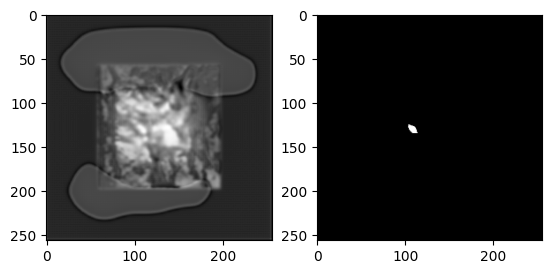

In [26]:
plt.subplot(1,2,1)
plt.imshow(pred, cmap="gray")
plt.subplot(1,2,2)
plt.imshow(m, cmap="gray")
plt.show()